<a href="https://colab.research.google.com/github/ACCMouli/chandu/blob/main/lllms/analysis/5_sentiment_customr_llmbatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Customer Text Sentiment Analysis

In [1]:
#!pip install OpenAI
#!pip install langchain
#!pip install langchain_community
#!pip install Cohere
!pip install langchain-openai langchain-cohere python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.4/295.4 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: httpx-sse
    Found existing installation: httpx-sse 0.4.1
    Uninstalling httpx-sse-0.4.1:
      Successfully uninstalled httpx-sse-0.4.1
  Attempting uninstall: langchain-core
    Fo

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
from google.colab import userdata

In [3]:

import os, json, re
import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# --------------------
# CONFIG - EDIT HERE
# --------------------
CSV_PATH = r"https://github.com/giridhar276/genai/raw/refs/heads/main/datasets/Bank_Customer_conversations.csv"   # default to the generated CSV in this environment
TEXT_COL = "customer_text"
MODEL = "gpt-4o-mini"
TEMPERATURE = 0
BATCH_SIZE = 40
TIMEOUT = 60
BINARY_OUTPUT = False

OUTPUT_PATH = CSV_PATH.replace(".csv", "_with_sentiment.csv")

# You must set OPENAI_API_KEY in your environment before running:
openai_key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai_key
assert os.getenv("OPENAI_API_KEY"), "Please set OPENAI_API_KEY in your environment."


In [4]:

def strict_json_parse(s):
    try:
        return json.loads(s)
    except Exception:
        pass
    m = re.search(r"\{.*\}", s, flags=re.DOTALL)
    if not m:
        return {"label": "neutral", "confidence": 0.33, "reason": "fallback: parse error"}
    try:
        return json.loads(m.group(0))
    except Exception:
        return {"label": "neutral", "confidence": 0.33, "reason": "fallback: json error"}




In [5]:
def postprocess_label(label: str, binary: bool = False) -> str:
    label = (label or "").strip().lower()
    if label not in {"positive", "neutral", "negative"}:
        label = "neutral"
    if binary:
        return "positive" if label == "positive" else "negative"
    return label



In [6]:
def clean_text(x: str) -> str:
    if not isinstance(x, str):
        return ""
    x = x.replace("\r", " ").replace("\n", " ").strip()
    x = re.sub(r"\s+", " ", x)
    return x

In [7]:

df = pd.read_csv(CSV_PATH)
df["customer_text"] = df[TEXT_COL].astype(str).map(clean_text)
df = df[df[TEXT_COL].str.len() > 0].copy()
df.reset_index(drop=True, inplace=True)

print("Rows:", len(df))
df.head(3)


Rows: 30


,call_id,topic,tone,customer_text
0,CALL20250915-0001,card_block_unblock,harsh,Ms. Patel: My card ending 0530 got blocked aft...
1,CALL20250915-0002,loan_approval_status,harsh,Ms. Patel: I filed a loan application 27-Aug-2...
2,CALL20250915-0003,loan_approval_status,frustrated,Mr. Singh: I filed a loan application 30-Aug-2...


In [8]:

SYSTEM = """You are a strict sentiment classifier for short customer utterances from bank call transcripts.
Return ONLY a compact JSON object on a SINGLE LINE with keys:
- "label": one of "positive", "neutral", "negative"
- "confidence": a number in [0,1]
- "reason": a brief rationale (<= 15 words)
Judge tone + wording; ignore bank-specific facts. Prefer "neutral" if mixed.
No extra text before/after JSON.
"""

USER_TMPL = '''Classify the sentiment of the CUSTOMER text below.
Rules:
- Output strictly ONE LINE of JSON only.
- Labels: "positive" | "neutral" | "negative".
- Keep "reason" short (<= 15 words).
- Consider tone: polite, frustrated, aggressive, harsh.
CUSTOMER:
""" {text} """'''



In [9]:

llm = ChatOpenAI(model=MODEL, temperature=TEMPERATURE, timeout=TIMEOUT)

def build_messages(txt: str):
    return [SystemMessage(content=SYSTEM), HumanMessage(content=USER_TMPL.format(text=txt))]


In [10]:

labels, confs, reasons = [], [], []

def classify_batch(msgs):
  results = llm.batch(msgs)
  return [strict_json_parse(x.content) for x in results]

buffer = []
for i, txt in enumerate(df[TEXT_COL].tolist(), start=1):
    buffer.append(build_messages(txt))
    if len(buffer) >= BATCH_SIZE:
        objs = classify_batch(buffer)
        for o in objs:
            labels.append(postprocess_label(o.get("label"), BINARY_OUTPUT))
            confs.append(float(o.get("confidence", 0.5)))
            reasons.append(o.get("reason", ""))
        buffer = []
        if i % (BATCH_SIZE * 5) == 0:
            print(f"Processed {i}/{len(df)} rows...")

if buffer:
    objs = classify_batch(buffer)
    for o in objs:
        labels.append(postprocess_label(o.get("label"), BINARY_OUTPUT))
        confs.append(float(o.get("confidence", 0.5)))
        reasons.append(o.get("reason", ""))

assert len(labels) == len(df), "Batching length mismatch—check logic."


In [11]:
if df.empty:
    raise RuntimeError("DataFrame is empty—upstream step failed (CSV read or LLM).")

df["sentiment_label"] = labels
df["sentiment_confidence"] = confs
df["sentiment_reason"] = reasons


In [12]:
df

,call_id,topic,tone,customer_text,sentiment_label,sentiment_confidence,sentiment_reason
0,CALL20250915-0001,card_block_unblock,harsh,Ms. Patel: My card ending 0530 got blocked aft...,negative,0.85,Frustrated tone and harsh language used.
1,CALL20250915-0002,loan_approval_status,harsh,Ms. Patel: I filed a loan application 27-Aug-2...,negative,0.85,Frustrated tone and harsh wording about servic...
2,CALL20250915-0003,loan_approval_status,frustrated,Mr. Singh: I filed a loan application 30-Aug-2...,negative,0.85,Frustration expressed over delays and inconven...
3,CALL20250915-0004,loan_approval_status,polite,Mr. Verma: I filed a loan application 10-Sep-2...,neutral,0.80,Polite inquiry with no strong sentiment expres...
4,CALL20250915-0005,insurance_claim_status,frustrated,Ms. Patel: I submitted an insurance claim 22-A...,negative,0.85,Frustration due to delay and inconvenience exp...
5,CALL20250915-0006,insurance_new_policy,polite,Mr. Khan: I’m considering a term insurance pla...,neutral,0.80,Polite inquiry with no strong sentiment expres...
6,CALL20250915-0007,insurance_new_policy,harsh,Mr. Khan: I’m considering a term insurance pla...,negative,0.85,Frustrated tone and harsh wording about servic...
7,CALL20250915-0008,card_block_unblock,frustrated,Mr. Iyer: My card ending 6566 got blocked afte...,negative,0.85,Frustration due to inconvenience and delay.
8,CALL20250915-0009,insurance_claim_status,frustrated,Mr. Singh: I submitted an insurance claim 12-S...,negative,0.85,Frustration due to delay and inconvenience exp...
9,CALL20250915-0010,loan_approval_status,aggressive,Ms. Chawla: I filed a loan application 30-Aug-...,negative,0.90,Frustrated tone and demand for resolution.


In [13]:
counts = df["sentiment_label"].value_counts().sort_index()
print("\nLabel counts:\n", counts)



Label counts:
 sentiment_label
negative    17
neutral     13
Name: count, dtype: int64


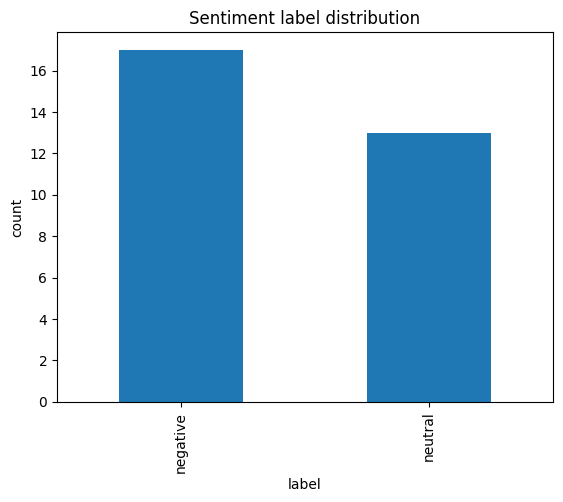

In [14]:
plt.figure()
counts.plot(kind="bar")
plt.title("Sentiment label distribution")
plt.xlabel("label")
plt.ylabel("count")
plt.show()
